## **Python for Quantitative Trading: Futures**
### **Integrated CTA Strategies Episode 3 - More Factors**

In [1]:
import numpy as np
import pandas as pd
import math
import gzip
import _pickle as cPickle
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

import os
from helper import *
from stats import *
from product_info import *
import helper
import stats
import dask
from dask import compute, delayed


plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' #在notebook中可以更好的显示，svg输出是一种向量化格式，缩放网页并不会导致图片失真。这行代码似乎只用在ipynb文件中才能使用。

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 
pd.set_option('display.max_columns', None) #防止column太多中间变成省略号


In [2]:
from imp import reload  
reload(helper)
reload(stats)

<module 'stats' from 'd:\\self_learning_python\\self_learning\\My_Strategies_CTA\\stats.py'>

In [11]:
HEAD_PATH = r"E:\My_Strategies_CTA" 
DATA_PATH = HEAD_PATH + "\\pkl_tick" 
NIGHT_PATH = HEAD_PATH + "\\night_pkl_tick\\"
SAVE_PATH = r"E:\My_Strategies_CTA"  #保存计算的因子数据的地方
SIGNAL_PATH = r"E:\My_Strategies_CTA" 
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [12]:
product_list = ["rb", "hc", "i", "j", "jm"]
product = product_list[0] #随便取一个商品期货，可以更改
print(product)
all_dates = os.listdir(DATA_PATH + "\\" + product)
all_dates.sort()
n_days = len(all_dates)
print(len(all_dates), all_dates[:6])

rb
1063 ['20170103.pkl', '20170104.pkl', '20170105.pkl', '20170106.pkl', '20170109.pkl', '20170110.pkl']


In [5]:
# 任意取一个品种的一天的数据读取出来
date = all_dates[0][:8] #随便取一天，可以更改
print(date)
data = load(DATA_PATH + '\\' + product +"\\" + date + ".pkl") 
display(data)

20170103


,contract,date.time,price,cum.open.int,open.int,turnover,qty,bid,ask,bid.qty,ask.qty,date,time,milli,good,mid.price,buy.trade,buy2.trade,sell.trade,sell2.trade,log.price,ret,wpr,wpr.ret,next.ask,next.bid,min.1024,max.1024,min.2048,max.2048,min.4096,max.4096
0,rb1705,2016-12-29 20:59:00.500,2948.0,2463004,-1278,152293680.0,5166,2948.0,2949.0,13,471,20161229,20:59:00,500,False,2948.5,2583.0,0.0,2583.0,0.0,7.988891,-0.001347,2948.026860,-3.973140,2948.0,2947.0,2948.026860,2948.026860,2948.026860,2948.026860,2948.026860,2948.026860
1,rb1705,2016-12-29 21:00:00.500,2948.0,2462508,-496,27822120.0,944,2947.0,2948.0,53,530,20161229,21:00:00,500,False,2947.5,0.0,0.0,244.0,700.0,7.988574,-0.000318,2947.090909,-0.935950,2947.0,2946.0,2947.090909,2948.026860,2947.090909,2948.026860,2947.090909,2948.026860
2,rb1705,2016-12-29 21:00:01.000,2947.0,2462656,148,25638280.0,870,2946.0,2947.0,3,478,20161229,21:00:01,0,False,2946.5,0.0,0.0,808.0,62.0,7.988206,-0.000368,2946.006237,-1.084672,2946.0,2944.0,2946.006237,2948.026860,2946.006237,2948.026860,2946.006237,2948.026860
3,rb1705,2016-12-29 21:00:01.500,2944.0,2462908,252,27512360.0,934,2944.0,2946.0,107,406,20161229,21:00:01,500,False,2945.0,0.0,0.0,606.0,328.0,7.987666,-0.000540,2944.417154,-1.589083,2944.0,2943.0,2944.417154,2948.026860,2944.417154,2948.026860,2944.417154,2948.026860
4,rb1705,2016-12-29 21:00:02.000,2943.0,2462876,-32,19491800.0,662,2943.0,2944.0,35,3,20161229,21:00:02,0,False,2943.5,126.0,0.0,536.0,0.0,7.987498,-0.000169,2943.921053,-0.496101,2944.0,2943.0,2943.921053,2948.026860,2943.921053,2948.026860,2943.921053,2948.026860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109640,rb1705,2017-01-04 14:59:58.500,2928.0,2531438,232,16987040.0,580,2928.0,2929.0,35,2,20170104,14:59:58,500,False,2928.5,0.0,0.0,464.0,116.0,7.982398,-0.000062,2928.945946,-0.182932,2930.0,2929.0,2927.871698,2956.027068,2924.544118,2956.027068,2891.444444,2956.027068
109641,rb1705,2017-01-04 14:59:59.000,2929.0,2531412,-26,4744840.0,162,2929.0,2930.0,54,366,20170104,14:59:59,0,False,2929.5,148.0,0.0,14.0,0.0,7.982460,0.000062,2929.128571,0.182625,2930.0,2929.0,2927.871698,2956.027068,2924.544118,2956.027068,2891.444444,2956.027068
109642,rb1705,2017-01-04 14:59:59.500,2930.0,2531646,234,18511820.0,632,2929.0,2930.0,1,240,20170104,14:59:59,500,False,2929.5,54.0,0.0,578.0,0.0,7.982418,-0.000042,2929.004149,-0.124422,2930.0,2928.0,2927.871698,2956.027068,2924.544118,2956.027068,2891.444444,2956.027068
109643,rb1705,2017-01-04 15:00:00.000,2930.0,2531598,-48,7323460.0,250,2928.0,2930.0,4,202,20170104,15:00:00,0,False,2929.0,96.0,0.0,154.0,0.0,7.982088,-0.000330,2928.038835,-0.965314,2930.0,2928.0,2927.871698,2956.027068,2924.544118,2956.027068,2891.444444,2956.027068


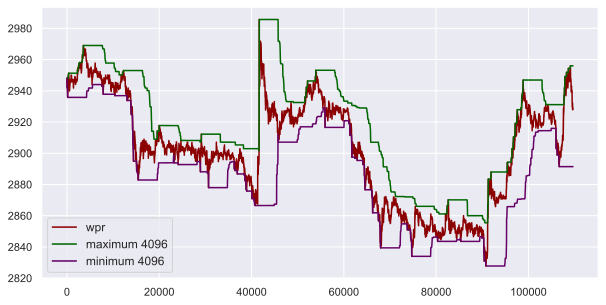

In [6]:
# plot the maximum price of 2048 ticks
# plot the minimum price of 2048 ticks
sns.set_theme()
plt.figure(1, figsize=(10, 5))
plt.plot(data["wpr"].values, label="wpr", color="darkred")
plt.plot(data["max.4096"].values, label="maximum 4096", color="#006600")
plt.plot(data["min.4096"].values, label = "minimum 4096", color="#660066")
plt.grid(True)
plt.legend(fontsize=12)

In [20]:
# 设置参数
period = 4096

**测试第一个因子**
- 计算买量变化量和卖量变化量，并只记signal为1或-1或0而不计入绝对数值，然后作差计算净变化量情况，再滑动计算ewma，同样是adjust，并且吸取之前的经验，是先计算指标再取rolling，而不是各自取rolling之后再计算指标

In [14]:
from collections import OrderedDict
class factor_dbook_period(factor_template):
    factor_name = "dbook.period"
    
    # params初始设为4096
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values

In [15]:
x3 = factor_dbook_period()
# 直接写x3就可以自动调用__repr__方法，打印具体信息，极其方便
x3

factor_name:
dbook.period

formula:
    def formula(self, data, period):
        diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values


params:
$period:[4096]

In [16]:
# 创建因子路径
for product in product_list:
    create_signal_path(x3, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\dbook.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\dbook.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\i\dbook.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\j\dbook.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\jm\dbook.4096


In [17]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH + "\\" +product +"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 3min 20s


In [27]:
def get_all_signal(file_list, product, signal_name, period):
    n_files = len(file_list)
    to_choose = (np.arange(n_files)+1) % 10 == 0
    all_signal = np.array([])
    for file in file_list[to_choose]:
        S = load(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+signal_name+"\\"+file)
        data = load(HEAD_PATH+"\\pkl_tick\\"+product+"\\"+file)
        signal = S[data["good"]]
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    return all_signal

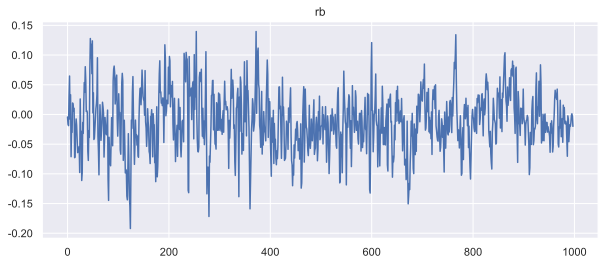

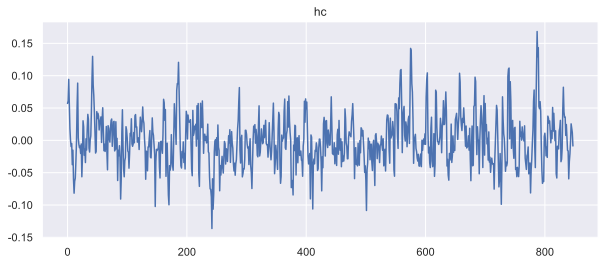

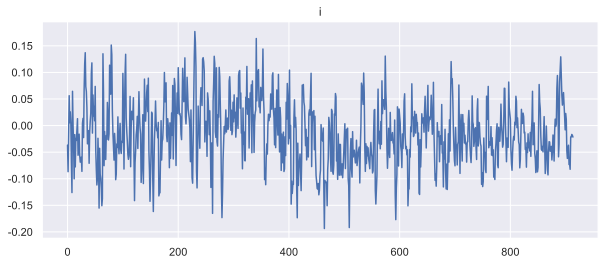

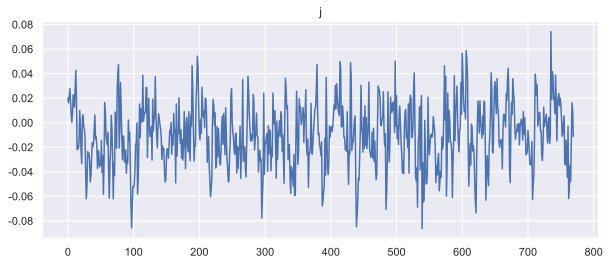

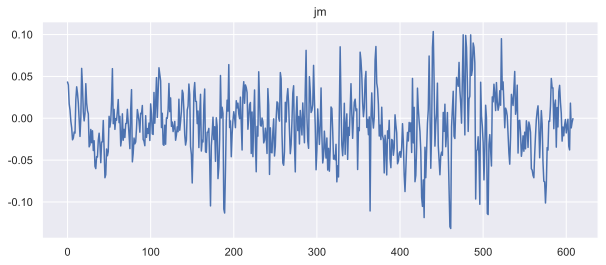

In [21]:
i = 0
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "dbook."+str(period), period)
    i = i+1
    plt.figure(i, figsize=(10, 4))
    plt.title(product)
    plt.plot(all_signal)

In [22]:
print(len(all_signal))

609


**检验是否有极值**

In [23]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.05, 0.15, 0.005)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)

(100, 2)

**划分训练集和测试集**

In [24]:
period = 4096
signal_name = "dbook."+str(period)

# 19年以前为训练，19年后为测试
train_sample = np.array(all_dates) < "2019"
print(sum(train_sample))
test_sample = np.array(all_dates) > "2019"
print(sum(test_sample))

487
576


先在全体数据上跑一下看看效果如何

In [29]:
%%time
signal_name = "dbook."+str(period)
all_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=tranct, max_spread=spread+0.1, tranct_ratio=tranct_ratio, 
                                       HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

Wall time: 11min 24s


In [30]:
save(all_trade_stat, HEAD_PATH+"\\processed_data\\"+"black_trade_stat_"+signal_name+".pkl")

In [31]:
all_trade_stat = load(HEAD_PATH+"\\processed_data\\"+"black_trade_stat_"+signal_name+".pkl")

In [32]:
date_str = [n[0:8] for n in all_dates]

format_dates = np.array([pd.to_datetime(d) for d in date_str])

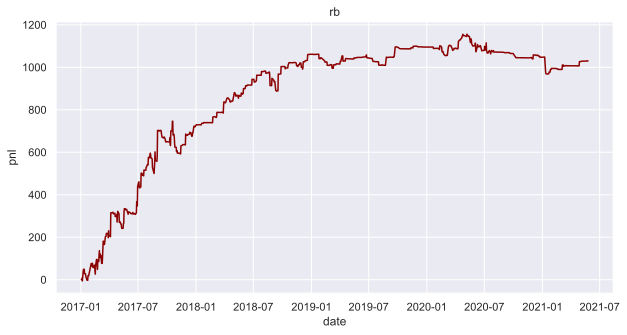

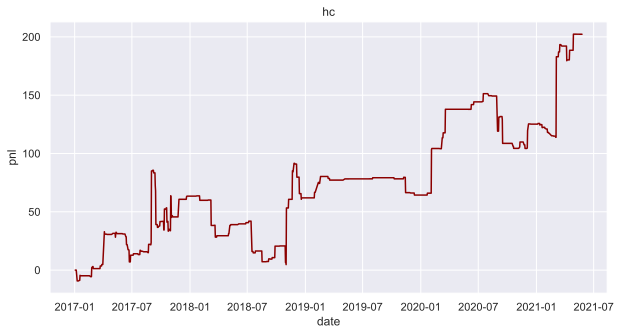

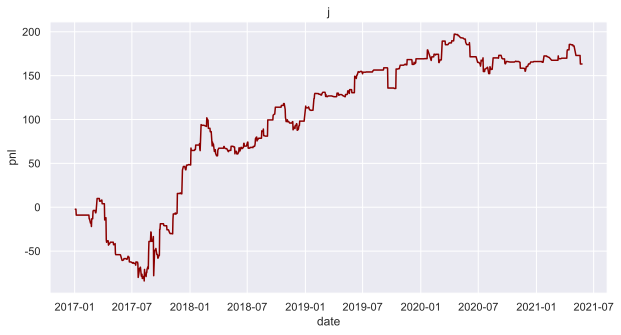

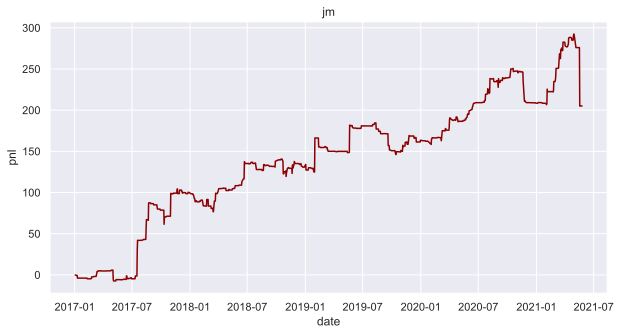

In [33]:
i = 0
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    if sum(good_strat)>2:
        good_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(10, 5))
        plt.title("")
        plt.xlabel("date")
        plt.ylabel("pnl")
        plt.title(product)
        plt.plot(format_dates, good_pnl.cumsum(), color="darkred")

效果还可以，在train上跑结果

In [34]:
%%time
train_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=tranct, max_spread=spread+0.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(train_sample))
    train_trade_stat[product] = trade_stat
    

Wall time: 6min 31s


In [35]:
save(train_trade_stat, HEAD_PATH+"\\processed_data\\" + signal_name+"_black_train_trade_stat.pkl")

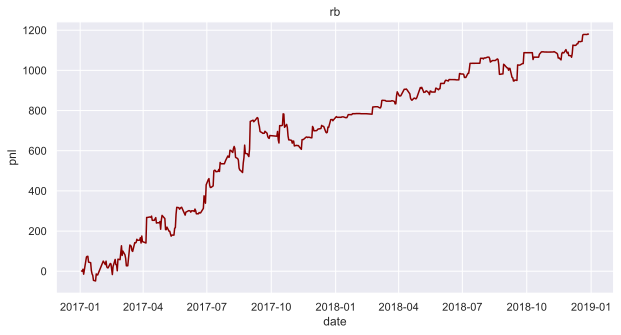

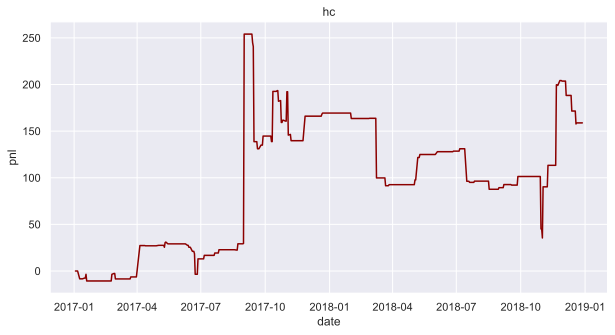

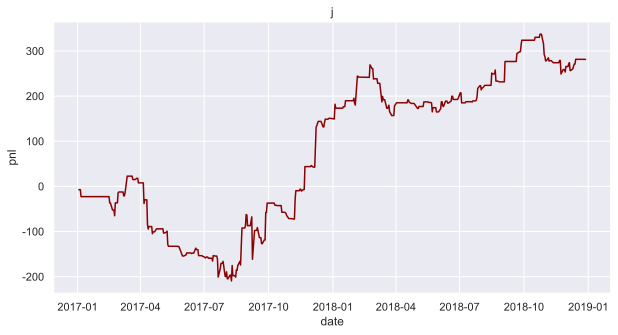

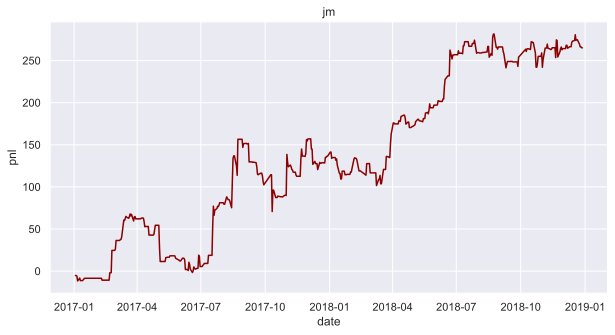

In [36]:
i = 0
train_trade_stat = load(HEAD_PATH+ "\\processed_data\\" + signal_name +"_black_train_trade_stat.pkl")
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>2*spread) & (trade_stat["final.result"]["num"]>20)
    if sum(good_strat)>0:
        good_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(10, 5))
        plt.title("")
        plt.xlabel("date")
        plt.ylabel("pnl")
        plt.title(product)
        plt.plot(format_dates[train_sample], good_pnl.cumsum(), color='darkred')

在test上验证

In [37]:
%%time
test_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=tranct, max_spread=spread+0.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(test_sample))
    test_trade_stat[product] = trade_stat


Wall time: 5min 50s


In [38]:
save(test_trade_stat, HEAD_PATH + "\\processed_data\\" + signal_name + "_test_trade_stat.pkl")

rb train sharpe  1.8288563078081765 test sharpe  -0.46754268375977953
hc train sharpe  0.37483900810114323 test sharpe  0.7961904818127113
j train sharpe  0.7640820968299206 test sharpe  0.5321634012899968
jm train sharpe  1.1825140445777882 test sharpe  0.004681210760920137


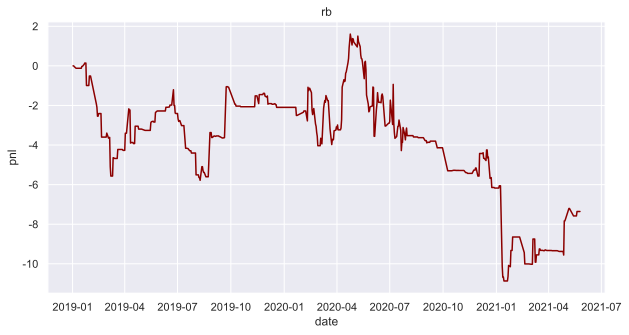

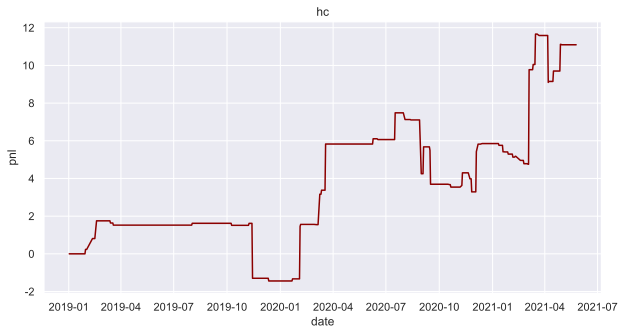

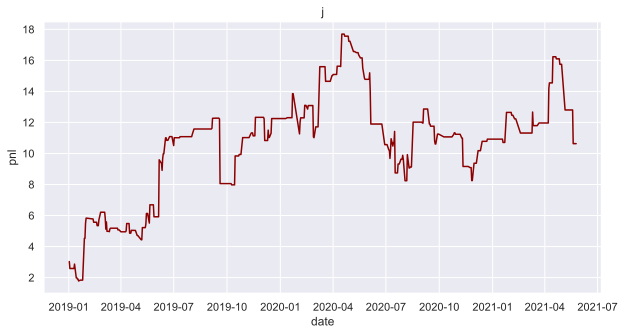

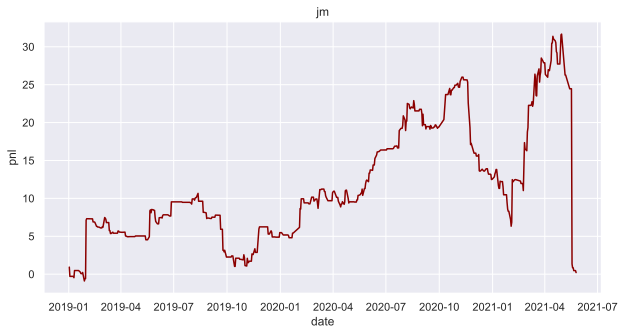

In [39]:
i = 0
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>2*spread) & (trade_stat["final.result"]["num"]>20)
    if sum(good_strat)>0:
        train_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        train_std = np.std(train_pnl)
        train_pnl = train_pnl/train_std
        trade_stat = test_trade_stat[product]
        test_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
        print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
        test_all_pnl[:,i] = test_pnl
        train_all_pnl[:,i] = train_pnl
        i = i+1
        plt.figure(i, figsize=(10,5))
        plt.title("")
        plt.xlabel("date")
        plt.ylabel("pnl")
        plt.title(product)
        plt.plot(format_dates[test_sample], test_pnl.cumsum(), color="darkred")

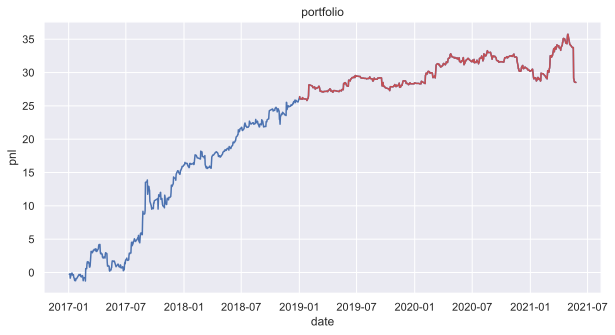

In [42]:
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
all_portfolio
plt.figure(1, figsize=(10,5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.title("portfolio")
plt.plot(format_dates, all_portfolio.cumsum(), color="b")
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample], color="r")
    

In [43]:
print(sharpe(train_portfolio), sharpe(test_portfolio))

1.8134022443384357 0.25120248438906956


**把上述的划分集合以及回测过程给封装进函数**

In [44]:
## get backtest result of a signal on a product's list
from collections import OrderedDict
def get_list_signal_stat(signal_name, thre_mat_list, product_list, all_dates, atr_filter_list,
                    split_str="2018", min_pnl=2, min_num=20, reverse=1):
    CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
    train_sample = np.array(all_dates)<split_str ## training samples
    test_sample = np.array(all_dates)>split_str ## test samples
    date_str = [n[0:8] for n in all_dates] ## date string
    format_dates = np.array([pd.to_datetime(d) for d in date_str]) ## date in xxxx-xx-xx format
    train_trade_stat = dict([]) ## training result statistics
    print("training")
    for product in product_list:
        print(product)
        spread = product_info[product]["spread"] ## get product's bid/ask spread
        tranct = product_info[product]["tranct"] ## get product's transaction cost
        tranct_ratio = product_info[product]["tranct.ratio"] ## True: tranct cost based on notional; False: fix cost
        thre_mat = thre_mat_list[product]
        atr_filter = atr_filter_list[product]
        with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
            f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                      reverse=reverse, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                      HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                      atr_filter=atr_filter)
            train_result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
        trade_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
        train_trade_stat[product] = trade_stat
    print("testing")
    test_trade_stat = dict([])
    for product in product_list:
        print(product)
        spread = product_info[product]["spread"]
        tranct = product_info[product]["tranct"]
        tranct_ratio = product_info[product]["tranct.ratio"]
        thre_mat = thre_mat_list[product]
        atr_filter = atr_filter_list[product]
        with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
            f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                     reverse=reverse, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio,
                                      HEAD_PATH = HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                      atr_filter=atr_filter)
            result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
        trade_stat = get_hft_summary(result, thre_mat, sum(test_sample))
        test_trade_stat[product] = trade_stat
    result=dict([])
    result["train_trade_stat"] = train_trade_stat ## save train stat
    result["test_trade_stat"] = test_trade_stat ## save test stat
    if reverse==-1:
        save(result, HEAD_PATH+"\\processed_data\\"+signal_name+".result.pkl") ## reversal strategy
    else:
        save(result, HEAD_PATH+"\\processed_data\\"+signal_name+".pos.result.pkl") ## trend strategy

In [45]:
## get train and test result, choose good strategies, plot the portfolio and result of each product

def get_list_signal_result(signal_name, product_list, all_dates, split_str="2018", reverse=1,
                           min_pnl=2, min_num=20):
    if reverse==-1:
        result = load(HEAD_PATH+"\\processed_data\\"+signal_name+".result.pkl") ## load reversal strat statistics
    else:
        result = load(HEAD_PATH+"\\processed_data\\"+signal_name+".pos.result.pkl") ## load trend strat statistics
    train_trade_stat = result["train_trade_stat"]
    test_trade_stat = result["test_trade_stat"]
    train_sample = np.array(all_dates)<split_str
    test_sample = np.array(all_dates)>split_str
    date_str = [n[0:8] for n in all_dates]
    format_dates = np.array([pd.to_datetime(d) for d in date_str])
    i = 0
    test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
    train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
    for product in product_list:
        spread = product_info[product]["spread"]
        trade_stat = train_trade_stat[product]
        ## two criterion: minimum averge pnl (unit is spread), monimum number of trades
        good_strat = (trade_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (trade_stat["final.result"]["num"]>min_num)
        if sum(good_strat)>0:
            train_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
            train_std = np.std(train_pnl)
            train_pnl = train_pnl/train_std
            trade_stat = test_trade_stat[product]
            test_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
            print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
            test_all_pnl[:,i] = test_pnl
            train_all_pnl[:,i] = train_pnl
            i = i+1
    if i>0:
        train_portfolio = np.array(np.mean(train_all_pnl[:,:i], axis=1))
        test_portfolio = np.array(np.mean(test_all_pnl[:,:i], axis=1))
        all_portfolio = np.append(train_portfolio, test_portfolio)
        plt.figure(1, figsize=(10, 5))
        plt.title("")
        plt.xlabel("date")
        plt.ylabel("pnl")
        plt.title("portfolio")
        plt.plot(format_dates, all_portfolio.cumsum())
        plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
        signal_stat = dict([])
        signal_stat["train.stat"] = train_trade_stat
        signal_stat["test.stat"] = test_trade_stat
        print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))

定义几个product的一些集合

In [46]:
atr_filter_list = dict([])
for product in product_list:
    atr_filter_list[product] = 0.01

In [47]:
reverse_list = dict([])
for product in product_list:
    reverse_list[product] = -1

In [48]:
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

使用封装函数对所有product进行train+test

In [49]:
%%time
signal_stat = get_list_signal_stat("dbook.4096", thre_mat_list, product_list, all_dates, atr_filter_list, 
                                   split_str="201901", min_pnl=2, min_num=20, reverse=-1)

training
rb
hc
i
j
jm
testing
rb
hc
i
j
jm
Wall time: 12min 31s


得到评价指标

rb train sharpe  1.848653577171791 test sharpe  -0.3974948789277934
hc train sharpe  0.40397675581011955 test sharpe  0.799436669622248
j train sharpe  0.6592791322541354 test sharpe  0.5887522124108437
jm train sharpe  1.1554199161980576 test sharpe  0.2519941308170817
train sharpe:  1.7837181373974285 test sharpe:  0.5271533750763512


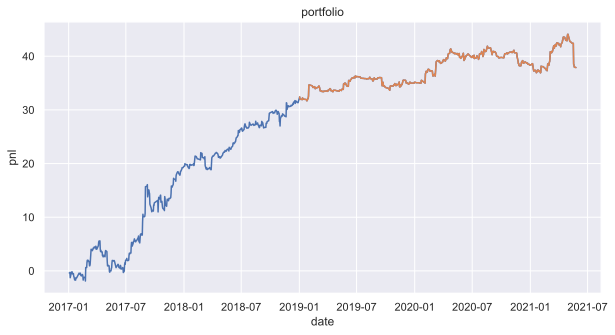

In [50]:
get_list_signal_result("dbook.4096", product_list, all_dates, split_str="201901", reverse=-1,
                    min_pnl=2, min_num=20)

**第二个因子**
- 使用一段时间的wpr，rolling的wpr最小值和rolling的wpr最大值（这两个值的计算其实很费功夫，原始数据已经计算好了），然后做一个差值的EWMA，见get_range_pos的details

In [51]:
from collections import OrderedDict
class factor_range_pos_period(factor_template):
    factor_name = "range.pos.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return get_range_pos(data["wpr"], data["min."+str(period)], data["max."+str(period)], period).values

In [52]:
x4_1 = factor_range_pos_period()

In [53]:
for product in product_list:
    create_signal_path(x4_1, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\range.pos.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\range.pos.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\i\range.pos.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\j\range.pos.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\jm\range.pos.4096


In [54]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+ "\\" + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x4_1, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 3min 19s


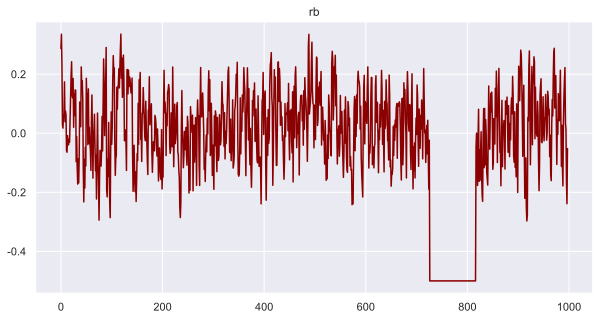

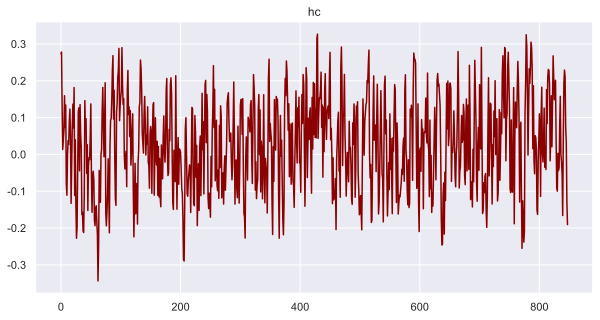

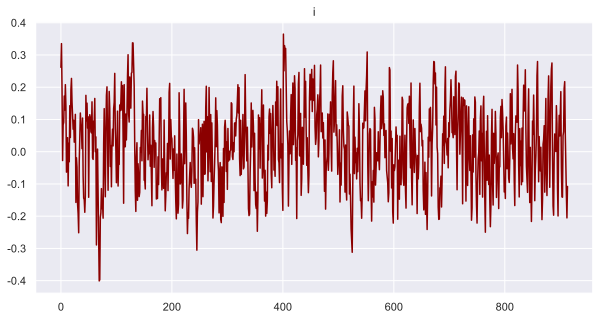

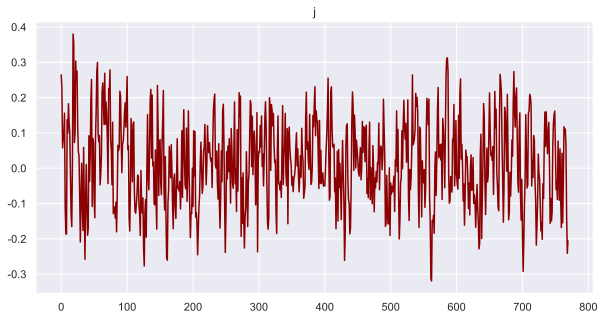

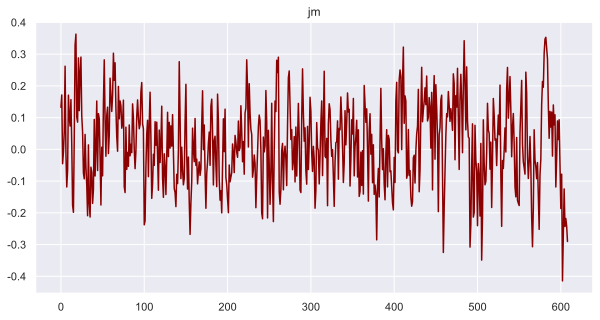

In [55]:
i = 0
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "range.pos."+str(period), period)
    i = i+1
    plt.figure(i, figsize=(10, 5))
    plt.title(product)
    plt.plot(all_signal, color="darkred")

In [56]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.1, 0.3, 0.01)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)

(100, 2)

同样对所有的product回测，在train上跑之后在test上验证。这个因子的计算和回测很慢要半个多小时，想想原因

In [57]:
%%time
signal_stat = get_list_signal_stat("range.pos.4096", thre_mat_list, product_list, all_dates, atr_filter_list, 
                                   split_str="2019", min_pnl=2, min_num=20, reverse=-1)

training
rb
hc
i
j
jm
testing
rb
hc
i
j
jm
Wall time: 31min 22s


In [61]:
signal_stat = get_list_signal_result("range.pos.4096", product_list, all_dates, split_str="2019", reverse=-1, 
                                   min_pnl=1, min_num=0)
signal_stat

根据我们get_list_signal_result的写法，如果在训练集的表现不好，那就不会有输出和画图，所以这里没有输出说明在训练集上的表现不好

**第三个因子**
- 对数收益率的EWMA除以对数收益率绝对值的EWMA

In [62]:
from collections import OrderedDict
class factor_nr_period(factor_template):
    factor_name = "nr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["ret"], period, adjust=True), ewma(data["ret"].abs(), period, adjust=True)).values

In [63]:
x5 = factor_nr_period()
for product in product_list:
    create_signal_path(x5, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\nr.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\nr.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\i\nr.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\j\nr.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\jm\nr.4096


In [64]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+ "\\" + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x5, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 3min 20s


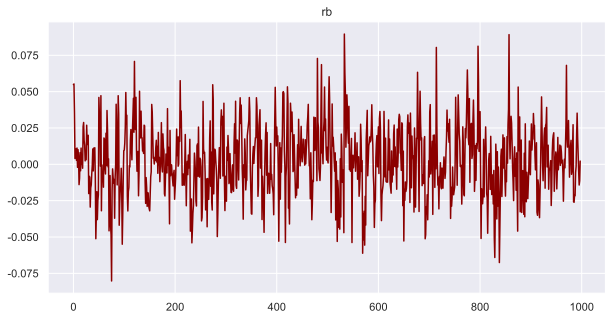

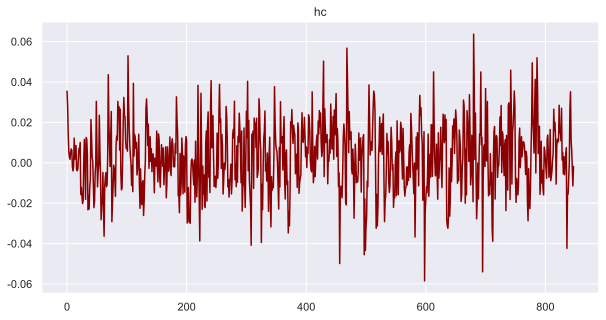

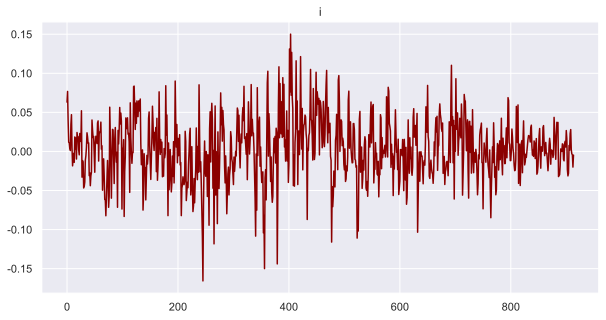

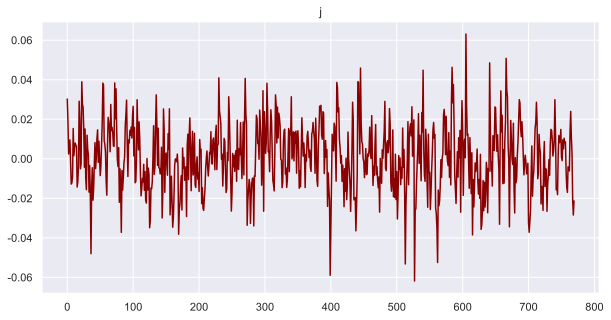

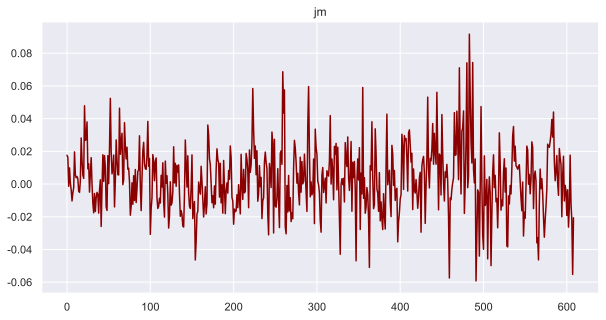

In [65]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "nr."+str(period), period)
    i = i+1
    plt.figure(i, figsize=(10, 5))
    plt.title(product)
    plt.plot(all_signal, color="darkred")

In [66]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.02, 0.08, 0.003)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)

(100, 2)

In [67]:
%%time
signal_stat = get_list_signal_stat("nr.4096", thre_mat_list, product_list, all_dates, atr_filter_list, 
                                   split_str="2019", min_pnl=2, min_num=20, reverse=-1)

training
rb
hc
i
j
jm
testing
rb
hc
i
j
jm
Wall time: 12min 20s


hc train sharpe  0.8777669135426442 test sharpe  -0.34543875753655123
j train sharpe  0.4623680157507946 test sharpe  0.25154528600416015
jm train sharpe  0.7775510188332375 test sharpe  -0.32278825736266853
train sharpe:  1.0865172389085755 test sharpe:  -0.17079208387732425


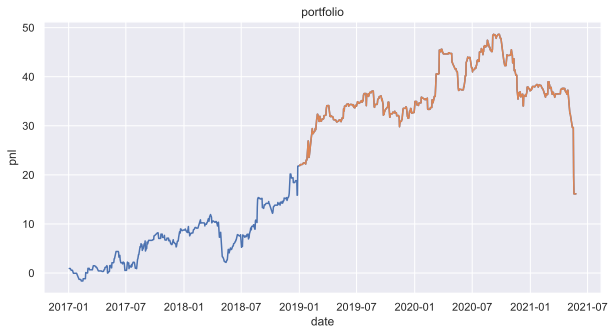

In [68]:
signal_stat = get_list_signal_result("nr.4096", product_list, all_dates, 
                                     split_str="2019", reverse=-1, min_pnl=2, min_num=20)

**第四个因子**
- wpr不同半衰期的EWMA的差值除以wpr

In [69]:
from collections import OrderedDict
class factor_ma_diff_period(factor_template):
    factor_name = "ma.dif.10.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/10), adjust=True) - ewma(data["wpr"], period, adjust=True), data["wpr"]).values

In [70]:
x99_1 = factor_ma_diff_period()

In [71]:
for product in product_list:
    create_signal_path(x99_1, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\ma.dif.10.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\ma.dif.10.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\i\ma.dif.10.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\j\ma.dif.10.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\jm\ma.dif.10.4096


In [72]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH + "\\" + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x99_1, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 3min 26s


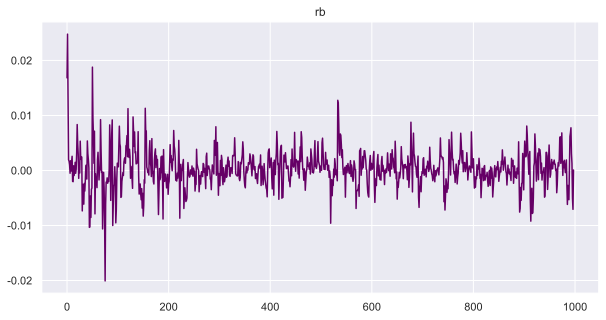

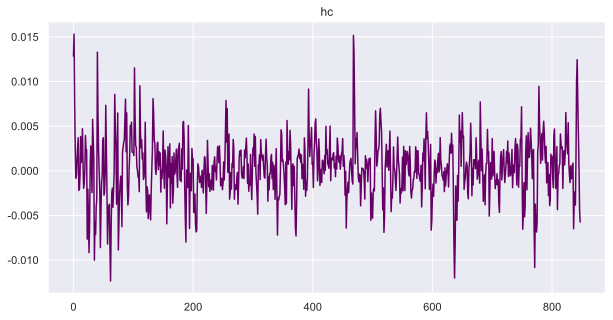

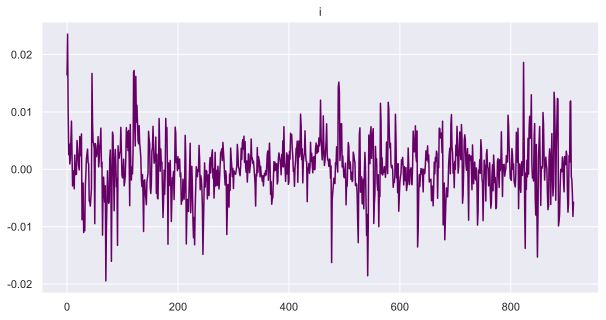

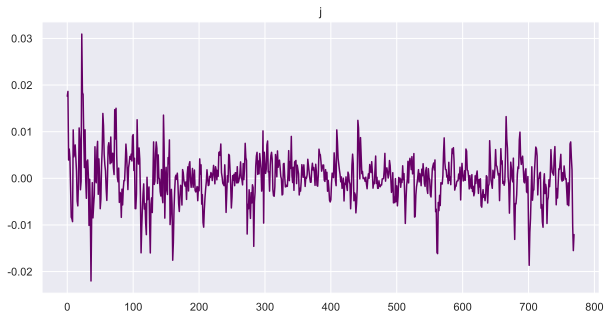

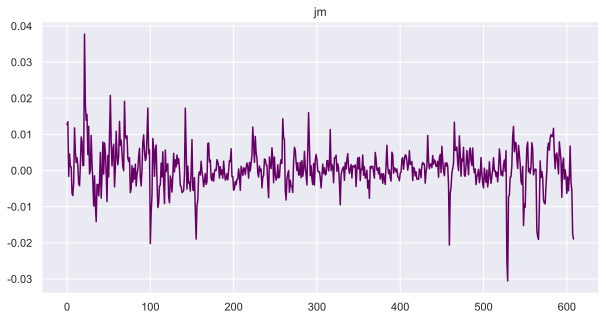

In [73]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "ma.dif.10."+str(period), period)
    i = i+1
    plt.figure(i, figsize=(10, 5))
    plt.title(product)
    plt.plot(all_signal, color="#660066")

In [74]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.005, 0.015, 0.0005)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)

(100, 2)

In [75]:
%%time
signal_stat = get_list_signal_stat("ma.dif.10.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str="2019", min_pnl=2, min_num=20, reverse=-1)

training
rb
hc
i
j
jm
testing
rb
hc
i
j
jm
Wall time: 5min 23s


In [76]:
signal_stat = get_list_signal_result("ma.dif.10.4096", product_list, all_dates, 
                                     split_str="2019", reverse=-1, min_pnl=0, min_num=0)

没有结果，因子效果不好。因子训练和测试只花了五分钟

**第五个因子：oscillation factor**
- 见定义

In [77]:
from collections import OrderedDict
class factor_price_osci_period(factor_template):
    factor_name = "price.osci.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/20), adjust=True)-ewma(data["wpr"], period, adjust=True), data["max."+str(period)]-data["min."+str(period)]).values

In [78]:
x113 = factor_price_osci_period()
for product in product_list:
    create_signal_path(x113, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\price.osci.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\price.osci.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\i\price.osci.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\j\price.osci.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\jm\price.osci.4096


In [79]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+"\\" + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal, signal_list=x113, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 3min 34s


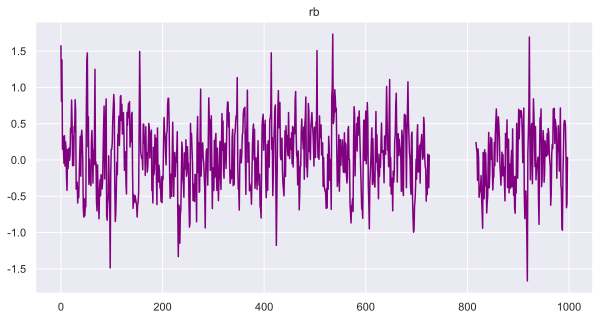

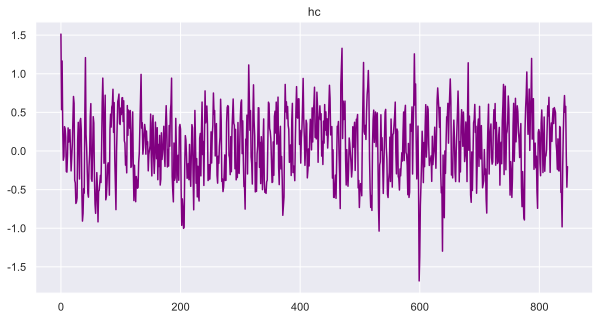

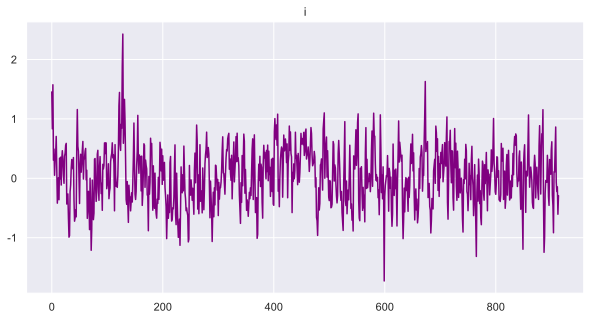

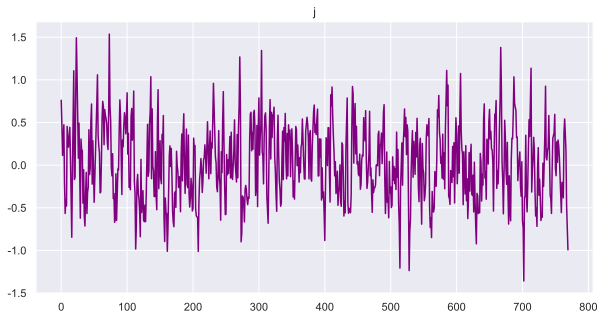

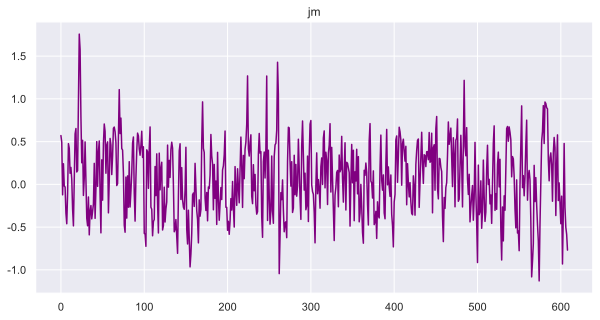

In [80]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "price.osci."+str(period), period)
    i = i+1
    plt.figure(i, figsize=(10, 5))
    plt.title(product)
    plt.plot(all_signal, color="purple")

In [81]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.6, 1, 0.02)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)

(100, 2)

In [82]:
%%time
signal_stat = get_list_signal_stat("price.osci.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str="2019", min_pnl=2, min_num=20, reverse=1)

training
rb
hc
i
j
jm
testing
rb
hc
i
j
jm
Wall time: 31min 48s


j train sharpe  0.17378155941508022 test sharpe  -0.6964148367949864
train sharpe:  0.17378155941508028 test sharpe:  -0.6964148367949881
Wall time: 131 ms


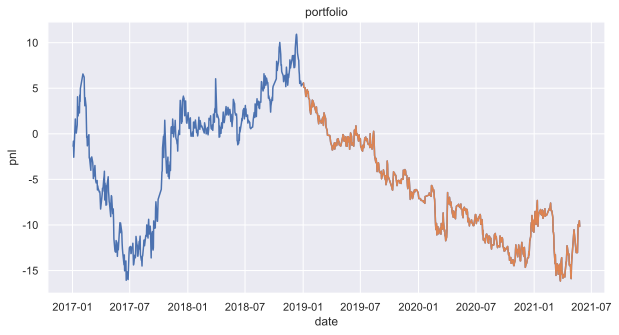

In [83]:
%%time
signal_stat = get_list_signal_result("price.osci.4096", product_list, all_dates, split_str="2019", reverse=1, min_pnl=0, min_num=10)

可以看到虽然oscillation factor的结果展现出来了因为训练集的表现还凑合，但是测试集一直跌，回撤也特别大

计算因子的偏度和峰度

In [84]:
from scipy.stats import kurtosis
from scipy.stats import skew

def get_signal_moment(signal, all_dates, product_list, period):
    for product in product_list:
        all_signal = get_all_signal(np.array(all_dates), product, signal+"."+str(period), period)
        print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))

In [85]:
%%time
get_signal_moment("dbook", all_dates, product_list, 4096)

rb kurtosis= 3.3292558260138123  skew= -0.03442115177889793
hc kurtosis= 4.077468679818463  skew= 0.46463064043994623
i kurtosis= 2.9673450716161205  skew= 0.13572601698943454
j kurtosis= 2.975546288388362  skew= -0.030524940731791936
jm kurtosis= 3.6810708556503924  skew= -0.051734226143421096
Wall time: 40.4 s


In [86]:
%%time
get_signal_moment("trade.imb", all_dates, product_list, 4096)

rb kurtosis= 3.29532912636656  skew= 0.12598575428566536
hc kurtosis= 3.5664109254717826  skew= -0.13690079095921548
i kurtosis= 3.331417755262715  skew= 0.06796812147137732
j kurtosis= 4.167959779845711  skew= -0.15955358268532033
jm kurtosis= 5.185580618897432  skew= 0.18431565003364936
Wall time: 40.5 s


In [87]:
%%time
get_signal_moment("range.pos", all_dates, product_list, 4096)

rb kurtosis= 4.100346674596123  skew= -1.1485255129347502
hc kurtosis= 2.3445315012956534  skew= -0.01156560438700087
i kurtosis= 2.5885098635774373  skew= -0.03704937909560492
j kurtosis= 2.590880667972659  skew= 0.08745425848418585
jm kurtosis= 2.7708793751945624  skew= -0.0012361839675433892
Wall time: 39.5 s


In [88]:
%%time
get_signal_moment("ma.dif.10", all_dates, product_list, 4096)

rb kurtosis= 9.321147233901037  skew= 0.4672669339031813
hc kurtosis= 5.301286256544197  skew= 0.16248324098370912
i kurtosis= 5.063381917978328  skew= 0.0037515924309908417
j kurtosis= 6.775306948493178  skew= 0.10940155703198291
jm kurtosis= 9.009921664999284  skew= -0.05069224257953774
Wall time: 40 s


In [89]:
%%time
get_signal_moment("price.osci", all_dates, product_list, 4096)

rb kurtosis= nan  skew= nan
hc kurtosis= 2.892972439136822  skew= -0.11546752593771438
i kurtosis= 3.6375440640845067  skew= 0.1626665768880947
j kurtosis= 2.855694414742262  skew= 0.14700242731239987
jm kurtosis= 3.103178716094204  skew= 0.16391147958756044
Wall time: 40 s


In [90]:
%%time
get_signal_moment("nr", all_dates, product_list, 4096)

rb kurtosis= 3.4026706281063013  skew= 0.10929041050476321
hc kurtosis= 3.373957878100351  skew= 0.010846374425513798
i kurtosis= 4.081882002522303  skew= -0.09087971440204498
j kurtosis= 3.470562821581134  skew= -0.016530696557462338
jm kurtosis= 4.326748044474971  skew= 0.35545705760852786
Wall time: 40.3 s


**最后测试两个因子：KDJ-K和KDJ-J**
- 尽管KDJ是A股最废指标，但是本来是起源于期货的短期趋势分析，因此期望可能期货市场的表现会好一些

In [91]:
class factor_kdj_k_period(factor_template):
    factor_name = "kdj.k.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5),
                   adjust=True).values
    

In [92]:
x11 = factor_kdj_k_period()
for product in product_list:
    create_signal_path(x11, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\kdj.k.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\kdj.k.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\i\kdj.k.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\j\kdj.k.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\jm\kdj.k.4096


In [93]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+"\\" + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x11, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 3min 22s


rb kurtosis= 2.1508507216023722  skew= -0.07707288699538488
hc kurtosis= 1.846707216058764  skew= -0.10306613148077597
i kurtosis= 1.8718173272037502  skew= -0.0498125302639752
j kurtosis= 1.951455952734895  skew= 0.020499155386247456
jm kurtosis= 1.9062516006135382  skew= -0.023197105994119047


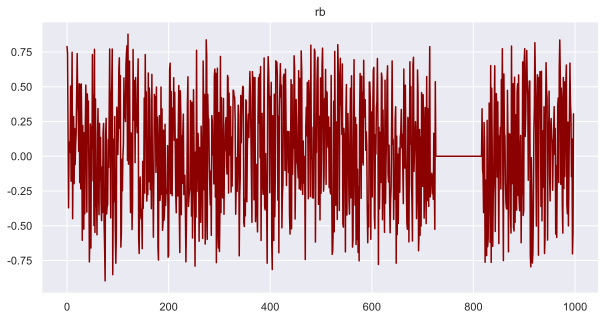

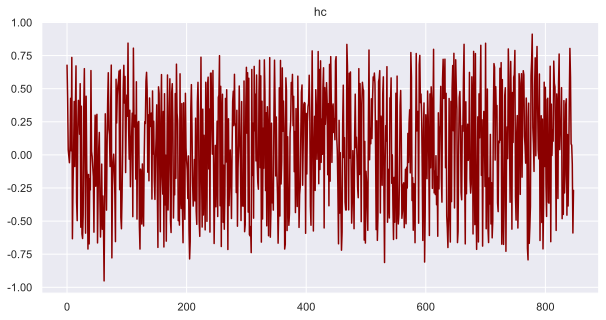

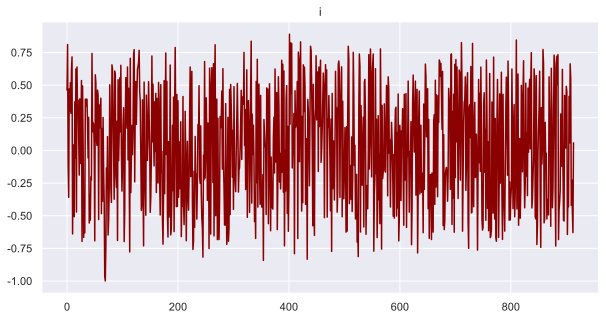

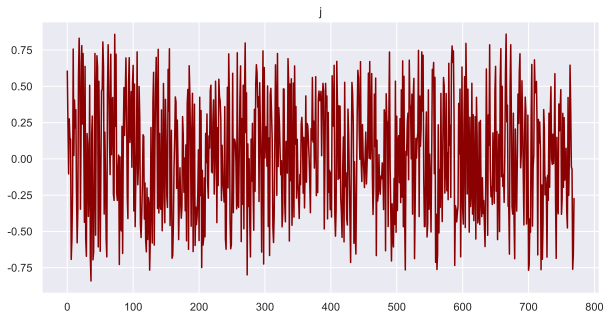

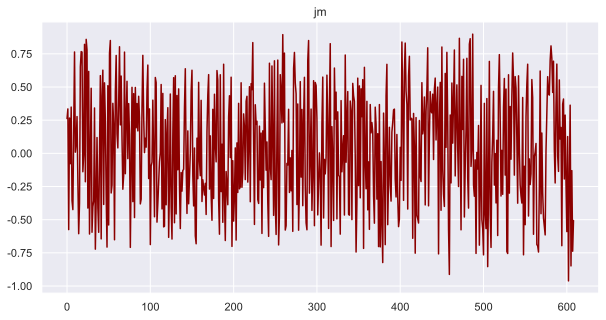

In [95]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "kdj.k."+str(period), period)
    i = i+1
    plt.figure(i, figsize=(10,5))
    plt.title(product)
    plt.plot(all_signal, color="darkred")
    print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))

In [97]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.5, 1, 0.025)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)

(100, 2)

In [98]:
%%time
signal_stat = get_list_signal_stat("kdj.k.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str = "2019", min_pnl=2, min_num=20,reverse=1)

training
rb
hc
i
j
jm
testing
rb
hc
i
j
jm
Wall time: 32min 27s


In [99]:
%%time
signal_stat = get_list_signal_result("kdj.k.4096", product_list, all_dates, split_str="2019", reverse=1, min_pnl=2, min_num=20)

Wall time: 127 ms


In [100]:
class factor_kdj_j_period(factor_template):
    factor_name = "kdj.j.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma(ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5),
                        adjust=True), round(period/5), adjust=True).values
    


In [101]:
x12 = factor_kdj_j_period()
for product in product_list:
    create_signal_path(x12, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\kdj.j.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\kdj.j.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\i\kdj.j.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\j\kdj.j.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\jm\kdj.j.4096


In [102]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+"\\" + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x12, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 3min 21s


rb kurtosis= 2.202880178028139  skew= -0.050931455354157176
hc kurtosis= 1.9405764783069952  skew= -0.05996039577822881
i kurtosis= 1.9545402378252819  skew= -0.06866226484644418
j kurtosis= 2.0515273150852105  skew= 0.0533548070147269
jm kurtosis= 2.15155367510045  skew= -0.009358898646399742
Wall time: 39.1 s


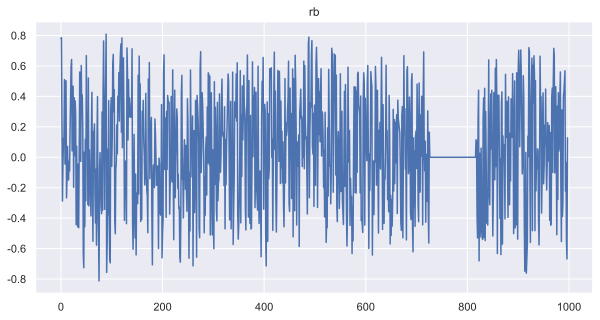

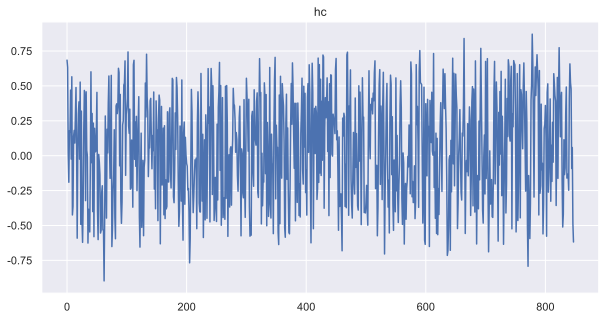

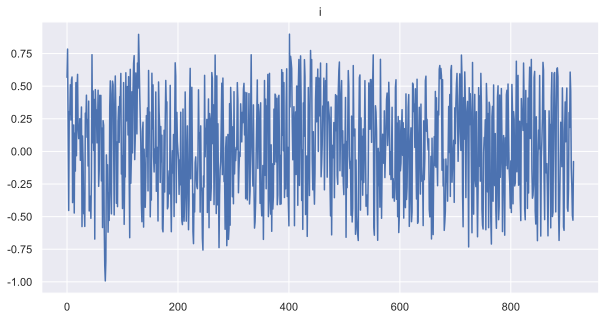

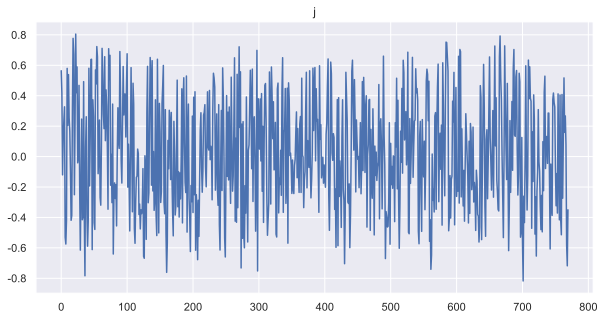

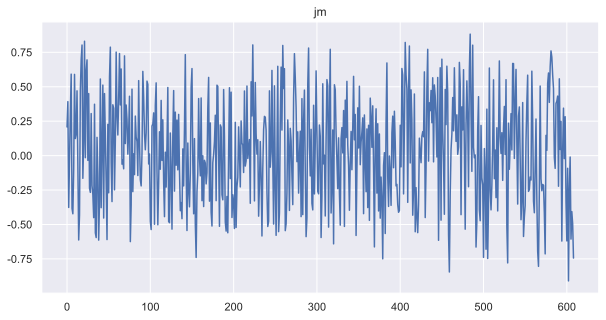

In [103]:
%%time
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "kdj.j."+str(period), period)
    i = i+1
    plt.figure(i, figsize=(10,5))
    plt.title(product)
    plt.plot(all_signal, color='darkred')
    print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))

In [104]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.5, 1, 0.025)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)

(100, 2)

In [105]:
%%time
signal_stat = get_list_signal_stat("kdj.j.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str = "2019", min_pnl=2, min_num=20,reverse=1)

training
rb
hc
i
j
jm
testing
rb
hc
i
j
jm
Wall time: 32min 17s


In [106]:
%%time
signal_stat = get_list_signal_result("kdj.j.4096", product_list, all_dates, split_str="2019", reverse=1, min_pnl=2, min_num=20)


Wall time: 122 ms


In [107]:
%%time
signal_stat = get_list_signal_stat("kdj.j.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str = "2019", min_pnl=2, min_num=20,reverse=-1)

training
rb
hc
i
j
jm
testing
rb
hc


In [ ]:
%%time
signal_stat = get_list_signal_result("kdj.j.4096", product_list, all_dates, split_str="2019", reverse=1, min_pnl=2, min_num=20)